In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [4]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [6]:
#data.DCOILBRENTEU.to_numericd
#data.GOLDPMGBD228NLBM = data.GOLDPMGBD228NLBM.astype(dtype = np.float64)
#data['GOLDPMGBD228NLBM'][0]
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [7]:
btc_trace = go.Scatter(x=data.index, y=data['exukus'], name= 'exu')
py.iplot([btc_trace])

In [8]:
data['exukus'].replace(0, np.nan, inplace=True)
data['exukus'].fillna(method='ffill', inplace=True)

In [9]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [10]:
values = data['exukus'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
values

array([[0.5942],
       [0.5956],
       [0.5977],
       ...,
       [0.7825],
       [0.7708],
       [0.7713]], dtype=float32)

In [12]:
scaled

array([[0.34262943],
       [0.34661353],
       [0.3525896 ],
       ...,
       [0.8784859 ],
       [0.8451905 ],
       [0.8466134 ]], dtype=float32)

In [13]:
#split dataset into train and test, 70% train 30% test

In [14]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [15]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [16]:
look_back = 3 #use 3 previous days to predict the next day
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

5548
2377


In [17]:
trainX

array([[0.34262943, 0.34661353, 0.3525896 ],
       [0.34661353, 0.3525896 , 0.39328384],
       [0.3525896 , 0.39328384, 0.41605008],
       ...,
       [0.52105856, 0.51052916, 0.4874786 ],
       [0.51052916, 0.4874786 , 0.46784282],
       [0.4874786 , 0.46784282, 0.45702899]], dtype=float32)

In [18]:
trainY

array([0.39328384, 0.41605008, 0.40239036, ..., 0.46784282, 0.45702899,
       0.44223094], dtype=float32)

In [19]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
trainX

array([[[0.34262943, 0.34661353, 0.3525896 ]],

       [[0.34661353, 0.3525896 , 0.39328384]],

       [[0.3525896 , 0.39328384, 0.41605008]],

       ...,

       [[0.52105856, 0.51052916, 0.4874786 ]],

       [[0.51052916, 0.4874786 , 0.46784282]],

       [[0.4874786 , 0.46784282, 0.45702899]]], dtype=float32)

In [21]:
#run the model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 5548 samples, validate on 2377 samples
Epoch 1/50
5548/5548 [==============================] - 2s 291us/step - loss: 0.1824 - val_loss: 0.0439
Epoch 2/50
5548/5548 [==============================] - 0s 71us/step - loss: 0.0542 - val_loss: 0.0567
Epoch 3/50
5548/5548 [==============================] - 0s 70us/step - loss: 0.0304 - val_loss: 0.0618
Epoch 4/50
5548/5548 [==============================] - 0s 71us/step - loss: 0.0155 - val_loss: 0.0601
Epoch 5/50
5548/5548 [==============================] - 0s 71us/step - loss: 0.0140 - val_loss: 0.0242
Epoch 6/50
5548/5548 [==============================] - 0s 71us/step - loss: 0.0127 - val_loss: 0.0182
Epoch 7/50
5548/5548 [==============================] - 0s 68us/step - loss: 0.0126 - val_loss: 0.0175
Epoch 8/50
5548/5548 [==============================] - 0s 67us/step - loss: 0.0119 - val_loss: 0.0167
Epoch 9/50
5548/5548 [==============================] - 0s 66us/step - loss: 0.0122 - val_loss: 0.0174
Epoch 10/50
5548/5548 [=

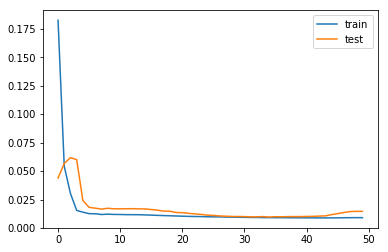

In [22]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

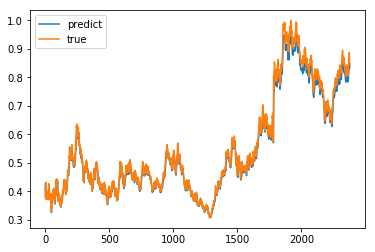

In [23]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [24]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [25]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.007


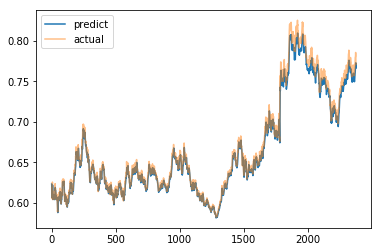

In [26]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [27]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [28]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

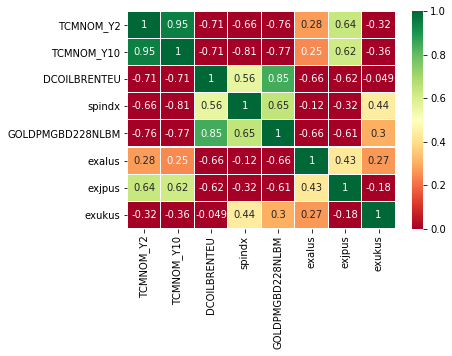

In [29]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [104]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [105]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [106]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [107]:
#normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [108]:
values

array([[2.78210e+02, 8.05000e+00, 8.92000e+00, ..., 1.38200e+00,
        1.39780e+02, 5.94200e-01],
       [2.80170e+02, 8.06000e+00, 8.87000e+00, ..., 1.38640e+00,
        1.40450e+02, 5.95600e-01],
       [2.82160e+02, 7.97000e+00, 8.78000e+00, ..., 1.38830e+00,
        1.40600e+02, 5.97700e-01],
       ...,
       [2.71174e+03, 2.87000e+00, 3.15000e+00, ..., 1.41040e+00,
        1.12860e+02, 7.82500e-01],
       [2.74037e+03, 2.84000e+00, 3.14000e+00, ..., 1.39100e+00,
        1.12790e+02, 7.70800e-01],
       [2.72306e+03, 2.91000e+00, 3.22000e+00, ..., 1.38910e+00,
        1.13090e+02, 7.71300e-01]], dtype=float32)

In [173]:
#convert data to become supervised 
look_back = 10
time_steps = 5
reframed = series_to_supervised(values, look_back, time_steps)
reframed

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t+3),var8(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4)
10,278.209991,8.05,8.92,18.629999,475.250000,1.3820,139.779999,0.5942,280.170013,8.06,...,142.500000,0.6020,297.470001,7.68,8.56,18.780001,455.649994,1.3916,142.449997,0.6030
11,280.170013,8.06,8.87,18.450001,469.100006,1.3864,140.449997,0.5956,282.160004,7.97,...,142.449997,0.6030,298.730011,7.66,8.52,18.680000,457.000000,1.3963,142.550003,0.6019
12,282.160004,7.97,8.78,18.549999,466.500000,1.3883,140.600006,0.5977,289.109985,7.79,...,142.550003,0.6019,301.619995,7.51,8.32,18.780001,455.450012,1.3924,143.850006,0.6053
28,304.760010,7.47,8.28,18.900000,452.750000,1.3904,144.449997,0.6120,304.809998,7.42,...,149.130005,0.6179,307.399994,7.36,8.28,19.500000,444.500000,1.4286,149.699997,0.6173
29,304.809998,7.42,8.23,19.030001,451.250000,1.3829,144.649994,0.6119,305.690002,7.44,...,149.699997,0.6173,308.290009,7.35,8.32,19.480000,446.399994,1.4166,150.570007,0.6181
30,305.690002,7.44,8.27,19.049999,452.200012,1.3850,144.600006,0.6136,306.970001,7.45,...,150.570007,0.6181,307.519989,7.38,8.37,19.680000,444.100006,1.4090,149.979996,0.6182
31,306.970001,7.45,8.30,19.049999,449.000000,1.3868,145.050003,0.6188,309.649994,7.42,...,149.979996,0.6182,308.390015,7.32,8.32,19.730000,444.750000,1.4130,150.649994,0.6198
32,309.649994,7.42,8.23,19.100000,438.000000,1.3864,145.899994,0.6270,308.429993,7.45,...,150.649994,0.6198,307.630005,7.36,8.38,19.830000,446.500000,1.4134,150.979996,0.6182
33,308.429993,7.45,8.23,18.900000,440.200012,1.3957,146.029999,0.6254,306.859985,7.54,...,150.979996,0.6182,310.679993,7.32,8.33,19.879999,447.000000,1.4144,151.080002,0.6208
34,306.859985,7.54,8.31,18.750000,441.750000,1.3941,145.080002,0.6165,308.959991,7.47,...,151.080002,0.6208,310.420013,7.37,8.43,20.280001,452.700012,1.4085,148.649994,0.6129


In [174]:
#look_back = 5
number_of_variables = 8
reframed.drop(reframed.columns[-1 * number_of_variables + 1:], axis=1, inplace=True)
print(reframed.head())

    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
10  278.209991        8.05        8.92   18.629999  475.250000      1.3820   
11  280.170013        8.06        8.87   18.450001  469.100006      1.3864   
12  282.160004        7.97        8.78   18.549999  466.500000      1.3883   
28  304.760010        7.47        8.28   18.900000  452.750000      1.3904   
29  304.809998        7.42        8.23   19.030001  451.250000      1.3829   

    var7(t-10)  var8(t-10)   var1(t-9)  var2(t-9)  ...  var8(t+2)   var1(t+3)  \
10  139.779999      0.5942  280.170013       8.06  ...     0.6103  297.279999   
11  140.449997      0.5956  282.160004       7.97  ...     0.6020  297.470001   
12  140.600006      0.5977  289.109985       7.79  ...     0.6030  298.730011   
28  144.449997      0.6120  304.809998       7.42  ...     0.6190  304.920013   
29  144.649994      0.6119  305.690002       7.44  ...     0.6179  307.399994   

    var2(t+3)  var3(t+3)  var4(t+3)   var5(t

In [175]:
reframed.drop(reframed.columns[look_back*number_of_variables:-1], axis=1, inplace=True)
print(reframed.head())

    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
10  278.209991        8.05        8.92   18.629999  475.250000      1.3820   
11  280.170013        8.06        8.87   18.450001  469.100006      1.3864   
12  282.160004        7.97        8.78   18.549999  466.500000      1.3883   
28  304.760010        7.47        8.28   18.900000  452.750000      1.3904   
29  304.809998        7.42        8.23   19.030001  451.250000      1.3829   

    var7(t-10)  var8(t-10)   var1(t-9)  var2(t-9)  ...  var8(t-2)   var1(t-1)  \
10  139.779999      0.5942  280.170013       8.06  ...     0.6085  293.470001   
11  140.449997      0.5956  282.160004       7.97  ...     0.6086  295.089996   
12  140.600006      0.5977  289.109985       7.79  ...     0.6161  293.450012   
28  144.449997      0.6120  304.809998       7.42  ...     0.6209  307.899994   
29  144.649994      0.6119  305.690002       7.44  ...     0.6247  304.000000   

    var2(t-1)  var3(t-1)  var4(t-1)   var5(t

In [176]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [177]:
scaled.shape

(5794, 81)

In [178]:
#splitting data 
n_train_hours = int(len(scaled) * 0.7)

In [179]:
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [180]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# target = -1 * number_of_variables
# look_back = 1
# number_of_variables = 8
# train_X, train_y = train[:, :(look_back * number_of_variables)], train[:, -1]
# test_X, test_y = test[:, :(look_back * number_of_variables) ], test[:, -1]

In [181]:
train_X

array([[0.01972349, 0.81340211, 0.85214452, ..., 0.41927172, 0.8042201 ,
        0.38613583],
       [0.02044784, 0.81443306, 0.84650116, ..., 0.42399515, 0.82220356,
        0.40761963],
       [0.02118326, 0.80515465, 0.83634313, ..., 0.42416694, 0.81620907,
        0.39902604],
       ...,
       [0.25957625, 0.09793815, 0.241535  , ..., 0.32119547, 0.20405222,
        0.41334857],
       [0.25665303, 0.09793815, 0.24379233, ..., 0.30891447, 0.20752903,
        0.40074469],
       [0.25813498, 0.09175258, 0.24604967, ..., 0.28916181, 0.22023731,
        0.38527634]])

In [182]:
train_y

array([0.02717201, 0.0276375 , 0.02870516, ..., 0.26865744, 0.26993199,
       0.26974358])

In [183]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4055, 1, 80) (4055,) (1739, 1, 80) (1739,)


In [184]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 4055 samples, validate on 1739 samples
Epoch 1/50
4055/4055 [==============================] - 2s 388us/step - loss: 0.0781 - val_loss: 0.1365
Epoch 2/50
4055/4055 [==============================] - 0s 75us/step - loss: 0.1563 - val_loss: 0.1816
Epoch 3/50
4055/4055 [==============================] - 0s 75us/step - loss: 0.0803 - val_loss: 0.1662
Epoch 4/50
4055/4055 [==============================] - 0s 72us/step - loss: 0.0802 - val_loss: 0.1680
Epoch 5/50
4055/4055 [==============================] - 0s 72us/step - loss: 0.0804 - val_loss: 0.1284
Epoch 6/50
4055/4055 [==============================] - 0s 69us/step - loss: 0.0755 - val_loss: 0.0542
Epoch 7/50
4055/4055 [==============================] - 0s 71us/step - loss: 0.0536 - val_loss: 0.0896
Epoch 8/50
4055/4055 [==============================] - 0s 71us/step - loss: 0.0665 - val_loss: 0.1493
Epoch 9/50
4055/4055 [==============================] - 0s 72us/step - loss: 0.0511 - val_loss: 0.1414
Epoch 10/50
4055/4055 [=

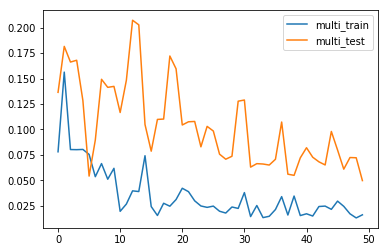

In [185]:
#plot result 
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

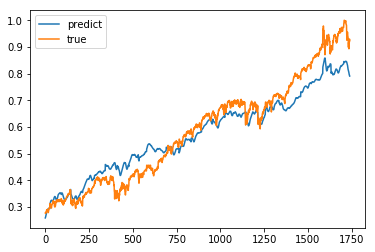

In [186]:
#plot prediction
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [187]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [188]:
test_X

array([[0.24819007, 0.08453609, 0.241535  , ..., 0.29208174, 0.21424283,
        0.38756798],
       [0.24904005, 0.08247423, 0.24266367, ..., 0.29294059, 0.22011749,
        0.39702089],
       [0.24250253, 0.08453609, 0.23702033, ..., 0.27739609, 0.22539257,
        0.37954739],
       ...,
       [0.9252082 , 0.27731959, 0.19977429, ..., 0.43550329, 0.44191343,
        0.86364946],
       [0.93953231, 0.27731959, 0.20090296, ..., 0.43344211, 0.44143386,
        0.87596685],
       [0.93349374, 0.27731959, 0.20203162, ..., 0.43275504, 0.43076368,
        0.87625317]])

In [189]:
#test_X[:, 1:]
yhat

array([[0.25936928],
       [0.26104605],
       [0.2634263 ],
       ...,
       [0.7948463 ],
       [0.79411733],
       [0.79085135]], dtype=float32)

In [190]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)

In [191]:
inv_yhat.shape

(1739, 81)

In [192]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [193]:
inv_yhat = inv_yhat[:,0]

In [194]:
inv_yhat

array([ 926.66993632,  931.2071198 ,  937.64786719, ..., 2375.6225409 ,
       2373.65002774, 2364.81258816])

In [195]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))

In [196]:
inv_y = concatenate((test_y, test_X[:, :]), axis=1)

In [197]:
inv_y

array([[0.27795243, 0.24819007, 0.08453609, ..., 0.29208174, 0.21424283,
        0.38756798],
       [0.27904967, 0.24904005, 0.08247423, ..., 0.29294059, 0.22011749,
        0.39702089],
       [0.28012841, 0.24250253, 0.08453609, ..., 0.27739609, 0.22539257,
        0.37954739],
       ...,
       [0.91908985, 0.9252082 , 0.27731959, ..., 0.43550329, 0.44191343,
        0.86364946],
       [0.92966685, 0.93953231, 0.27731959, ..., 0.43344211, 0.44143386,
        0.87596685],
       [0.92327189, 0.93349374, 0.27731959, ..., 0.43275504, 0.43076368,
        0.87625317]])

In [198]:
inv_y = scaler.inverse_transform(inv_y)

In [199]:
inv_y

array([[9.76954260e+02, 2.56744357e+00, 2.11898970e+00, ...,
        1.00082540e+02, 5.48592174e-01, 1.27300064e+03],
       [9.79923283e+02, 2.57568844e+00, 2.10072163e+00, ...,
        1.00154177e+02, 5.50643018e-01, 1.29858807e+03],
       [9.82842273e+02, 2.51227449e+00, 2.11898970e+00, ...,
        9.88576098e+01, 5.52484550e-01, 1.25129027e+03],
       ...,
       [2.71181443e+03, 9.13451921e+00, 3.82705143e+00, ...,
        1.12045332e+02, 6.28071978e-01, 2.56167228e+03],
       [2.74043482e+03, 9.27346312e+00, 3.82705143e+00, ...,
        1.11873409e+02, 6.27904561e-01, 2.59501334e+03],
       [2.72313065e+03, 9.21488893e+00, 3.82705143e+00, ...,
        1.11816101e+02, 6.24179602e-01, 2.59578838e+03]])

In [200]:
inv_y = inv_y[:,0]

In [201]:
inv_y

array([ 976.95426047,  979.92328275,  982.84227322, ..., 2711.81442742,
       2740.43482356, 2723.13064831])

In [202]:
inv_yhat

array([ 926.66993632,  931.2071198 ,  937.64786719, ..., 2375.6225409 ,
       2373.65002774, 2364.81258816])

In [203]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 164.525


In [204]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
#predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
#py.iplot([predict_chart, multi_predict_chart, actual_chart])
py.iplot([multi_predict_chart, actual_chart])